# Exploratory Data Analysis (Spain)

In [2]:
# Imports
import pandas as pd
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np
#import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller#, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Magic commands 
%matplotlib inline

Reading EDA output

In [3]:
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
eda_df = pd.read_csv("EDA_output.csv", 
                     converters={'EndTime': date_parser}).set_index('EndTime')

Basic Data Inspection

In [4]:
eda_df.head()

,country_code,quantity_sum,Load,surplus,CountryLabel
EndTime,,,,,
2022-01-01 00:00:00+00:00,DE,146300.0,166143,-19843.0,2
2022-01-01 01:00:00+00:00,DE,140324.0,161923,-21599.0,2
2022-01-01 02:00:00+00:00,DE,134063.0,158256,-24193.0,2
2022-01-01 03:00:00+00:00,DE,128745.0,157353,-28608.0,2
2022-01-01 04:00:00+00:00,DE,120346.0,155306,-34960.0,2


In [5]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67881 entries, 2022-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  67881 non-null  object 
 1   quantity_sum  67881 non-null  float64
 2   Load          67881 non-null  int64  
 3   surplus       67881 non-null  float64
 4   CountryLabel  67881 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 3.1+ MB


Filtering by Spain

In [6]:
deuchland_df = eda_df[eda_df['country_code'] == 'DE']

Scaling the signal to avoid negative value effects

In [7]:
eda_up_val = (deuchland_df['surplus'].min() * -1) + 1

In [8]:
# Scaling the surplus
deuchland_df.loc[:, 'surplus'] = deuchland_df['surplus'] + eda_up_val

Plotting 

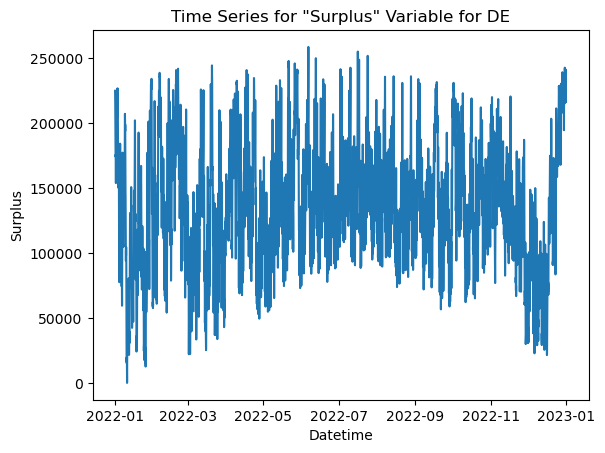

In [9]:
# Graficar la columna 'surplus'
plt.plot(deuchland_df.index, deuchland_df['surplus'])

# Añadir etiquetas y título
plt.xlabel('Datetime')
plt.ylabel('Surplus')
plt.title('Time Series for "Surplus" Variable for DE')

# Mostrar la leyenda si es necesario
# plt.legend(['quantity'])

# Mostrar el gráfico
plt.show()

To choose appropriate parameters for an ARIMA model, you can follow these steps:

**1. Stationarity Check**

First, check if your time series is stationary. This can be done using a statistical test, such as the Augmented Dickey-Fuller (ADF) test.

**2. Differencing**

If the time series is not stationary, apply differencing (d parameter in ARIMA) to make it stationary.

3. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
Once you have a stationary series, plot the ACF and PACF. These plots will help you determine the p and q parameters.

ACF: Helps to identify the Moving Average (MA) component, which corresponds to q.
PACF: Helps to identify the Autoregressive (AR) component, which corresponds to p.
4. Model Identification
Based on the ACF and PACF plots, you can identify initial values for p and q:

The lag where the PACF cuts off is the estimated p.
The lag where the ACF cuts off is the estimated q.
5. Iterative Process
Model selection is an iterative process. You may need to try different combinations of p, d, and q and use model selection criteria like AIC (Akaike Information Criterion) to find the best model.

#### 1. Check for Stationarity

In [10]:
# Check for stationarity
result = adfuller(deuchland_df['surplus'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# If p-value > 0.05, the series is not stationary and you need to difference it
# The null hypothesis that the series has a unit root (i.e., is non-stationary) cannot be rejected

ADF Statistic: -9.020848
p-value: 0.000000


The Augmented Dickey-Fuller (ADF) test is a common statistical test used to determine whether a given time series is stationary or not. The interpretation of the values given from an ADF test is as follows:

1. **ADF Statistic**: This is the test statistic used to reject or fail to reject the null hypothesis. The more negative the statistic, the stronger the rejection of the null hypothesis that the series has a unit root (i.e., is non-stationary).

   - In this case, the ADF Statistic is `-4.083998`. Since it's a negative value and depending on the critical values for the ADF test at different confidence levels (usually -3.5, -2.9, and -2.6 for the 1%, 5%, and 10% levels), a value of `-4.083998` is quite negative, which suggests that the null hypothesis can be rejected. This means the series is likely stationary.

2. **p-value**: This indicates the probability of observing the test results under the null hypothesis. In other words, it's the probability of finding the observed (or more extreme) results when the null hypothesis is true.

   - With a p-value of `0.001029`, which is less than 0.05 (a common threshold for statistical significance), you can reject the null hypothesis with high confidence. This low p-value indicates strong evidence against the null hypothesis, suggesting that the time series does not have a unit root and is stationary.

In conclusion, both the ADF statistic and the p-value indicate that the time series is stationary, and no differencing is needed if you are using this series to build an ARIMA model. It's always good practice to also compare the ADF statistic to the critical values provided in the test output to confirm this conclusion at different confidence levels.

#### 2. Applying Differencing (or not)

If the series is non-stationary (p-value > 0.05), the code then sets d = 1, which indicates that the series will be differenced once. The .diff(periods=d) function calculates the difference between each data point and the one d periods before it. The .dropna() part ensures that any NaN values created by the differencing (because the first d periods don't have d prior data points to subtract from) are removed.

In [11]:
# Apply differencing if needed and determine 'd'
if result[1] > 0.05:
    # Assuming one level of differencing makes the series stationary
    d = 1
    deuchland_df.loc[:, 'surplus_diff'] = deuchland_df['surplus'].diff(periods=d).dropna()
else:
    d = 0
    deuchland_df.loc[:, 'surplus_diff'] = deuchland_df['surplus']

/tmp/ipykernel_874/2385274544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deuchland_df.loc[:, 'surplus_diff'] = deuchland_df['surplus']


After applying differencing to a time series to achieve stationarity, plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) is crucial for:

1. **Identification of ARIMA Model Parameters**:
   - **AR (p)**: The PACF plot is used to identify the order of the Autoregressive (AR) part of an ARIMA model. The AR part captures the relationship between an observation and a certain number of lagged observations. The PACF plot shows the partial correlation of a stationarized series with its own lagged values, controlling for the values of the time series at all shorter lags. The point at which the PACF cuts off (the lag after which most PACF values are not significantly different from zero) is the suggested order of the AR component.
   
   - **MA (q)**: The ACF plot is used to identify the order of the Moving Average (MA) part of the ARIMA model. The MA part models the relationship between an observation and a residual error from a moving average model applied to lagged observations. The ACF plot shows the correlation of the series with its lags. Similar to the PACF, the point at which the ACF plot cuts off is the suggested order of the MA component.

2. **Insight into the Data**:
   - The ACF and PACF plots provide a visual insight into how the data is related to itself over time. For instance, if the ACF shows a slow decay, this indicates a long-term relationship in the data, which an ARIMA model might not capture without an appropriate differencing order (d).

3. **Model Diagnostics**:
   - After fitting the model, the ACF and PACF plots can be used for diagnostics to check for any autocorrelation in the residuals of the model. If there is significant autocorrelation in the residuals, the model may not be adequately capturing the structure of the time series, and further adjustments may be needed.

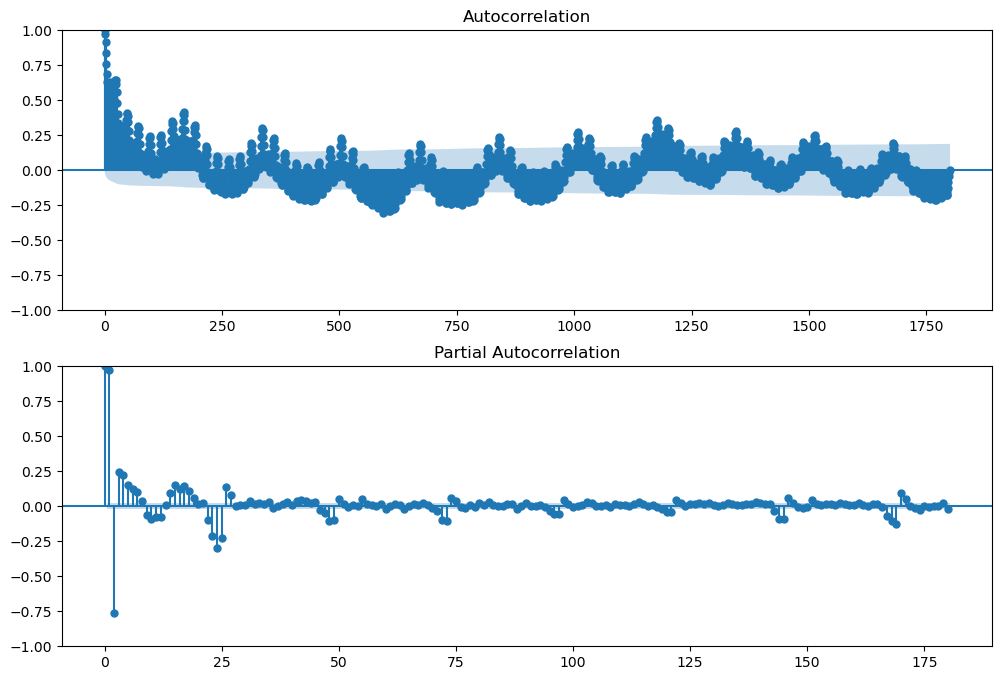

In [12]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(deuchland_df['surplus_diff'], lags=1800, ax=ax1)  # Change lags as needed
plot_pacf(deuchland_df['surplus_diff'], lags=180, ax=ax2)  # Change lags as needed
plt.show()

This ACF plot with an increased number of lags shows the following characteristics:

Gradual Decline: The ACF starts at 1 (as it always will for lag 0, because it's the correlation of the series with itself) and shows a very slow and gradual decline as the lags increase.

No Sharp Cutoff: There is no sharp cutoff point in the autocorrelation. Instead, it slowly diminishes, which suggests that the series may have a long memory. In other words, the current value of the series is likely influenced by many past values, not just recent ones.

Stationarity Concern: The fact that autocorrelation remains positive and slowly decays as lags increase may indicate that the time series is not stationary, even after differencing. This is often the case in time series with strong trend or seasonal components that have not been fully accounted for.

Model Implication: Such an ACF plot suggests that a simple ARIMA model might not be sufficient for capturing the underlying process of the time series. Instead, you might need to consider additional differencing to remove trends or seasonality, or even use models that can capture seasonality (like SARIMA) or trends (like ARIMA with a drift term) more explicitly.

Data Transformation: Before deciding on a model, further transformations or decompositions could be considered to better understand and model the underlying pattern.

### 2.1 Additional Processing Based on Findings

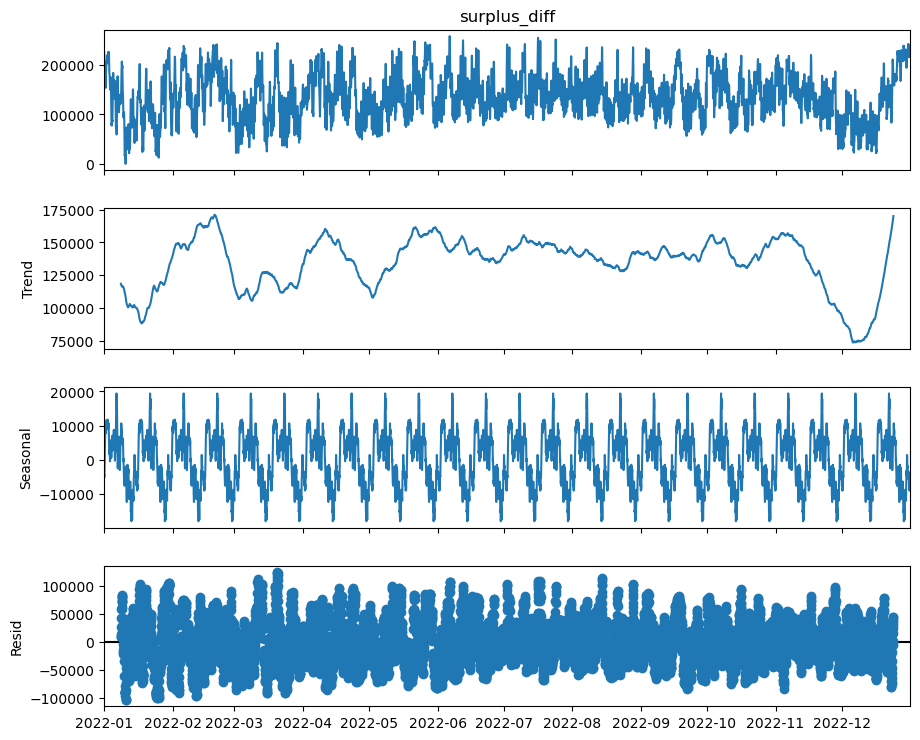

In [13]:
# Perform seasonal decomposition
# The period parameter should be set according to the known or suspected seasonality in your data
# For example, if you suspect annual seasonality in daily data, the period would be 365.
# For monthly data with annual seasonality, it would be 12.
result = seasonal_decompose(deuchland_df['surplus_diff'], model='additive', period=365)

# Plot the seasonal decomposition with an increased figure size
fig = result.plot()
fig.set_size_inches(10, 8)  # You can adjust the size as needed (width, height in inches)

# Show the plot
plt.show()

In [14]:
# Detrending
deuchland_df.loc[:, 'detrended'] = deuchland_df['surplus_diff'] - result.trend

# Seasonal Adjustment
deuchland_df.loc[:, 'seasonally_adjusted'] = deuchland_df['surplus_diff'] - result.seasonal

/tmp/ipykernel_874/3587678808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deuchland_df.loc[:, 'detrended'] = deuchland_df['surplus_diff'] - result.trend
/tmp/ipykernel_874/3587678808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deuchland_df.loc[:, 'seasonally_adjusted'] = deuchland_df['surplus_diff'] - result.seasonal


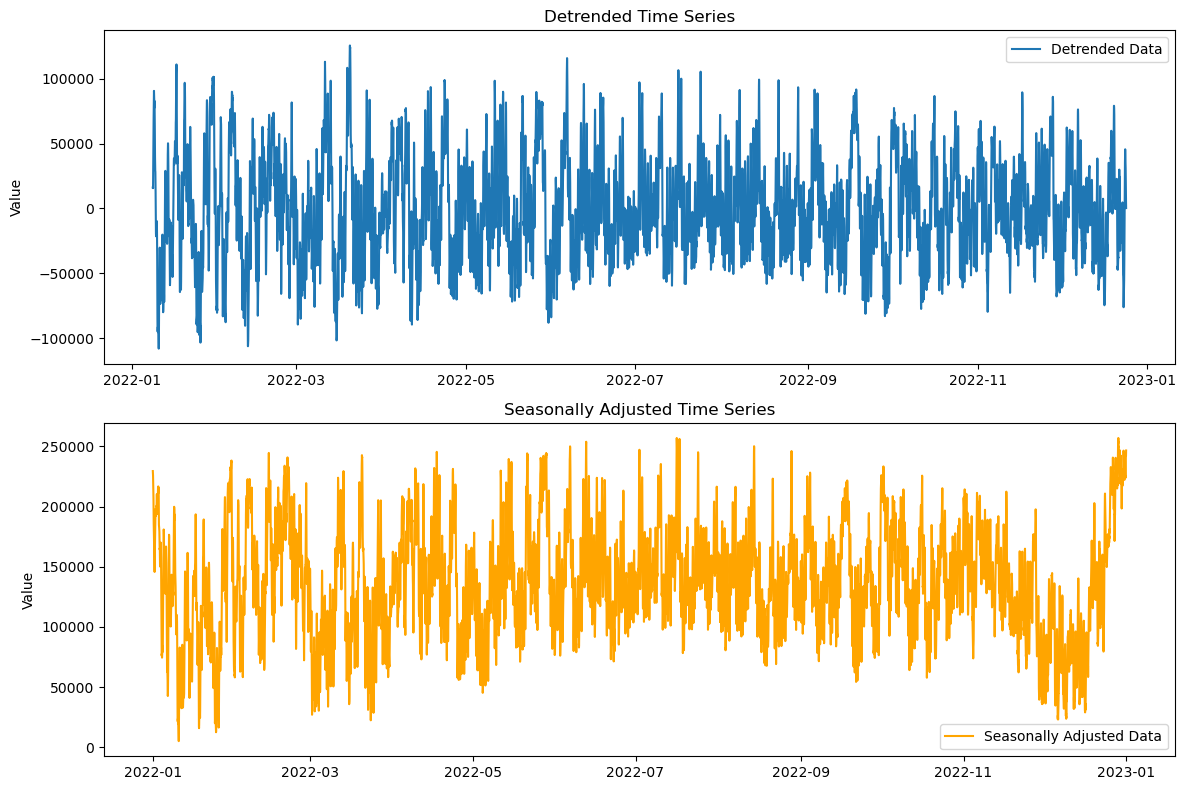

In [15]:
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Detrended data
axs[0].plot(deuchland_df.index, deuchland_df['detrended'], label='Detrended Data')
axs[0].set_title('Detrended Time Series')
axs[0].set_ylabel('Value')
axs[0].legend()

# Seasonally adjusted data
axs[1].plot(deuchland_df.index, deuchland_df['seasonally_adjusted'], label='Seasonally Adjusted Data', color='orange')
axs[1].set_title('Seasonally Adjusted Time Series')
axs[1].set_ylabel('Value')
axs[1].legend()

plt.tight_layout()
plt.show()

**Detrended Time Series (Top, Blue Plot)**:
- The detrended series has had the trend component removed.
- It fluctuates around a mean that appears to be close to zero, which is what you would expect after removing a trend.
- The variability in the series doesn't seem to diminish or increase over time, which is good as it suggests that the variance is relatively stable after detrending.
- You can now analyze this detrended series for cyclic patterns that are not part of the longer trend.

**Seasonally Adjusted Time Series (Bottom, Orange Plot)**:
- The seasonally adjusted series has had the seasonal component removed.
- The fact that it looks similar to the original series might suggest that the seasonal component was not very strong, or that the period used for seasonal decomposition was not correctly specified.
- If the seasonally adjusted series looks identical to the original series, it might indicate that the `seasonal_decompose` function did not properly identify and subtract the seasonal component from the original series.

The key here is understanding the period used for decomposition. The period parameter should correspond to the length of the seasonal cycle. For example, if the data is monthly and the seasonality is expected to repeat annually, the period should be 12. If the data is daily and you expect an annual cycle, then the period should be around 365.

However, since the data is hourly, an annual period of 365 would not be appropriate. Instead, the period should match the expected seasonal cycle in hours. For instance, if there's a daily pattern, the period might be 24 (for the number of hours in a day).

It's also possible that the seasonality in your data is not captured by additive decomposition due to the nature of the seasonal pattern. If the seasonality increases or decreases with the level of the time series, a multiplicative model might be more appropriate.

To address these points, you may need to:

1. Revisit the period used for seasonal decomposition and ensure it matches the expected seasonal cycle in your data.
2. Consider whether a multiplicative model would be more appropriate if the seasonality is proportional to the level of the time series (not an option since we have negative values).
4. Investigate alternative methods of seasonal adjustment if `seasonal_decompose` does not seem to be capturing the seasonality effectively.

Since data is sampled hourly and the seasonal pattern repeats twice per month (from the plot), we would need to calculate the period in terms of hours. Given that a month on average has about 30.44 days, and you're observing a pattern that repeats twice within that period, you can calculate the period as follows:

\[ \text{Period in hours} = \frac{\text{Average number of days in a month} \times 24 \text{ hours}}{\text{Number of cycles per month}} \]

\[ \text{Period in hours} = \frac{30.44 \times 24}{2} \]

Let's calculate that.

The correct value for the period, given that the seasonal pattern repeats twice per month, would be approximately 365.28 hours. When specifying the period for seasonal decomposition, you should round this to the nearest whole number. Therefore, you can use a period of 365 hours for the `seasonal_decompose` function.

In [16]:
# Average number of days in a month
average_days_per_month = 30.44

# Number of cycles per month
cycles_per_month = 2

# Calculate the period in hours
period_in_hours = (average_days_per_month * 24) / cycles_per_month
period_in_hours

365.28000000000003

Saving Processed Signal for Modeling

In [17]:
deuchland_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_code         8760 non-null   object 
 1   quantity_sum         8760 non-null   float64
 2   Load                 8760 non-null   int64  
 3   surplus              8760 non-null   float64
 4   CountryLabel         8760 non-null   int64  
 5   surplus_diff         8760 non-null   float64
 6   detrended            8396 non-null   float64
 7   seasonally_adjusted  8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 615.9+ KB


In [18]:
# Saving Spain DataFrame
deuchland_df.to_csv('EDA_countries/EDA_DE.csv')